<a href="https://colab.research.google.com/github/imrealhelper/Aerospace_experiment_2/blob/main/3%EC%A0%90%EA%B5%BD%ED%9E%98%EC%8B%9C%ED%97%98_plot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 데이터 전처리

In [198]:
import pandas as pd
from urllib.parse import quote
import matplotlib.pyplot as plt

base = "https://raw.githubusercontent.com/imrealhelper/Aerospace_experiment_2/main/"
fname = "굽힘시험 수직 raw.csv"
url = base + quote(fname)  # 공백/한글을 %로 인코딩

df1 = pd.read_csv(url, encoding="cp949")   # 또는 "utf-8-sig"
df1 = df1.iloc[1:]
display(df1)

,일련번호,시간,하중,변위,테이블,강도,변형율
1,1.0,0.000,0.0000,0.000000,0.001700,0.0000,0.000000
2,2.0,0.008,0.0000,0.002100,0.002100,0.0000,0.001406
3,3.0,0.025,0.0000,0.002400,0.002400,0.0000,0.001607
4,4.0,0.041,0.0000,0.002800,0.002800,0.0000,0.001875
5,5.0,0.057,0.0000,0.003200,0.003200,0.0000,0.002143
...,...,...,...,...,...,...,...
18826,18826.0,301.519,0.0178,7.468600,7.468600,0.0094,5.001295
18827,18827.0,301.535,0.0184,7.468900,7.468900,0.0097,5.001496
18828,18828.0,301.551,0.0184,7.469300,7.469300,0.0097,5.001763
18829,18829.0,301.569,0.0178,7.469700,7.469700,0.0094,5.002031


In [172]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18830 entries, 1 to 18830
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   일련번호    18830 non-null  float64
 1   시간      18830 non-null  object 
 2   하중      18830 non-null  object 
 3   변위      18830 non-null  object 
 4   테이블     18830 non-null  object 
 5   강도      18830 non-null  object 
 6   변형율     18830 non-null  object 
dtypes: float64(1), object(6)
memory usage: 1.0+ MB


In [199]:
df1["변위"] = df1["변위"].astype(float)
df1["하중"] = df1["하중"].astype(float)

In [174]:
df1["변위"].values

array([0.0000e+00, 2.1000e-03, 2.4000e-03, ..., 7.4693e+00, 7.4697e+00,
       7.4701e+00])

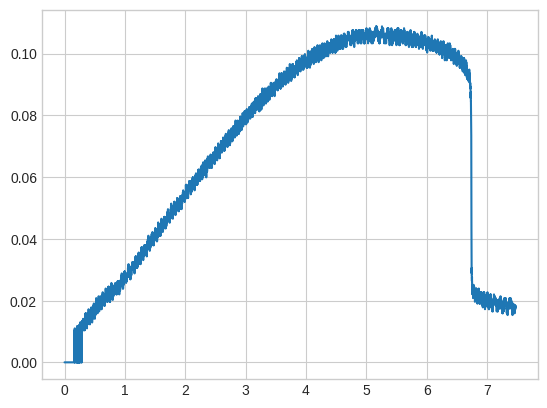

In [200]:
plt.plot(df1["변위"],df1["하중"])
plt.show()

## Savitzky–Golay filter

`Savitzky–Golay filter`란 등간격 데이터에 대해 신호 형태(피크 높이·위치 등)를 최대한 보존하면서 고주파 잡음을 줄이기 위한 형태 보존 스무딩/수치미분 필터이다.

이때 2D Savitzky–Golay filter
필터를 사용하기 위해 ` scipy.signal.savgol_filter`를 적용하여 아래와 같이 필터링을 수행하였다.



In [201]:
import numpy as np
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt

arr = np.vstack([df1["변위"].values, df1["하중"].values])  # (2, N)
arr_smooth = savgol_filter(arr, 11, 3, axis=1, mode='nearest')
print(arr_smooth)

[[8.49417249e-04 1.42400932e-03 2.05594406e-03 ... 7.46935268e+00
  7.46966457e+00 7.46990629e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.80419580e-02
  1.80139860e-02 1.79580420e-02]]


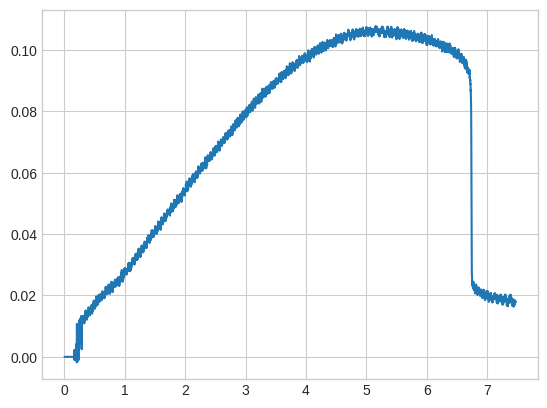

In [177]:
plt.plot(arr_smooth[0,:],arr_smooth[1,:])

Toe 보정(Toe Compensation)을 위해서는, 가장 가파르고 선형적인 초기 구간을 찾는 것이 중요하다.

이때 위 그래프를 보면

스텝함수 -> 덜 가파른 선형 구간 -> 가파른 선형구간 -> 소성 변형 구간(이차함수로 근사)로 이루어짐을 알 수 있다.

가파른 선형 구간을 찾기 위해서 아래와 같이 `Moving Window Least Squares` 방법을 정의하여 선형 구간이 시작되는 인덱스를 반환하도록 코드를 작성하였다.

크기가 $m$인 각 창(window)에서, 변위 $w$와 하중 $y$ 사이의 관계를 다음과 같은 2차 다항식으로 근사하였으며, 아래와 같이 나타난다.

$$ \hat{y_i} = a_1 {w_1}^2 + a_2 {w_1} + a_3 $$ 로 표현되며, 이때 $\hat{y}$는 모델이 예측한 값이다.
$$
\mathbf{y} =
\begin{bmatrix}
y_1 \\
y_2 \\
\vdots \\
y_m
\end{bmatrix},
\quad
\mathbf{X} =
\begin{bmatrix}
w_1^2 & w_1 & 1 \\
w_2^2 & w_2 & 1 \\
\vdots & \vdots & \vdots \\
w_m^2 & w_m & 1
\end{bmatrix},
\quad
\mathbf{c} =
\begin{bmatrix}
a_1 \\
a_2 \\
a_3
\end{bmatrix}
$$

이며
$$
\min_{\mathbf{c}} \| \mathbf{y} - \mathbf{X}\mathbf{c} \|_2^2
$$

문제로, Least squares 방법을 통해 풀 수 있다.

이때 추정된 `a_1`은 이차 함수의 곡률 (curvature)를 나타내는 계수이며, $|a_1|$가 크면 데이터가 많이 휘어져 있다는 의미이며, $|a_1|$가 작으면 데이터가 많이  데이터가 직선에 가깝다는 것을 알 수 있다.

아래 코드는 $|a_1|$이 가장 작은 것의 인덱스를 반환하는 코드이다.


In [202]:
Y = arr_smooth[1]
W = arr_smooth[0]

if not np.all(np.diff(W) >= 0):
    idx = np.argsort(W)
    W, Y = W[idx], Y[idx]

m = 6000  # 창 크기
curv = []   # 각 창의 이차미분 값(= 2*alpha)
betas = []  # (alpha, beta, gamma) 저장(필요시)
starts = [] # 창 시작 인덱스 기록

for i in range(len(Y) - m + 1):
    y = Y[i:i+m]
    w = W[i:i+m]

    X = np.column_stack([w**2, w, np.ones_like(w)])
    coef = np.linalg.lstsq(X, y, rcond=None)[0]  # coef = [alpha, beta, gamma]
    alpha, beta, gamma  = coef

    curv.append(2.0 * alpha)   # 곡률
    betas.append((alpha, beta, gamma))
    starts.append(i)

curv = np.array(curv)
starts = np.array(starts)

# 시각화: 곡률 절댓값이 작을수록 더 '직선'에 가까움

# 가장 선형(곡률 최소) 창 선택
best_idx = np.argmin(np.abs(curv))
i0 = starts[best_idx]
alpha, beta, gamma = betas[best_idx]

y_win = Y[i0:i0+m]
w_win = W[i0:i0+m]
X_lin = np.column_stack([w_win, np.ones_like(w_win)])   # y ≈ a w + b
(a_lin, b_lin), *_ = np.linalg.lstsq(X_lin, y_win, rcond=None)

w_win = W[i0:i0+m]; y_win = Y[i0:i0+m]
A = np.column_stack([w_win, np.ones_like(w_win)])
a_lin, b_lin = np.linalg.lstsq(A, y_win, rcond=None)[0]

c = -b_lin / a_lin                 # Toe offset (mm)
W_tc = W - c                       # 전 구간 보정

print(f"Best window start: {i0}")


Best window start: 1498


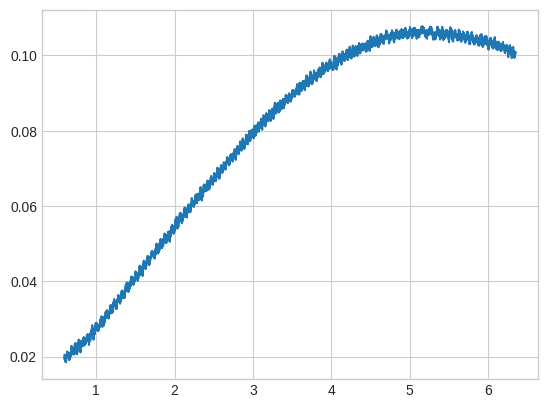

In [203]:
plt.plot(arr_smooth[0, i0:16000],arr_smooth[1, i0:16000])

하지만 여전히  덜 가파른 선형 구간이 미소하게 남아있어 이를 아래와 같이 최적화하였다.


아래 코드는 데이터를 세 구간으로 나누어, **선형-선형-이차함수** 형태로 이어지는 조각별 함수를 가장 잘 적합(fit)시키는 최적의 파라미터를 찾는 것을 목표로 한다. 이 모델은 다음과 같이 정의된다

$$
f(x) =
\begin{cases}
m_1 x + b_1 & \text{if } x < c_1 \\
m_2 (x - c_1) + f(c_1) & \text{if } c_1 \le x < c_2 \\
a_3 (x - c_2)^2 + m_2 (x - c_2) + f(c_2) & \text{if } x \ge c_2
\end{cases}
$$

여기서 찾아야 할 미지의 파라미터는 두 개의 접점(knot) $c_1, c_2$과 각 구간의 형태를 결정하는 **계수 $m_1, b_1, m_2, a_3$** 이다.


이때 접점 $c_1, c_2$가 미지수라는 점이며, 접점을 포함한 모든 변수를 동시에 최적화하는 것은 비볼록(non-convex) 문제로, 해를 찾기 매우 어렵다. 따라서 접점에 대한 격자 탐색과 볼록 최적화를 결합시켜 문제를 풀이하였다.




#### **1. 접점 ($c_1, c_2$)에 대한 격자 탐색 (Grid Search)**
최적의 접점 $c_1, c_2$를 직접 찾는 대신, 가능한 후보 값들의 격자(grid)를 생성하여 탐색 공간을 설정한다.
- 데이터의 양 끝 10%를 제외한 범위 내에서 `c1_candidates` 개수만큼 $c_1$의 후보군을 생성한다.
- 마찬가지로 `c2_candidates` 개수만큼 $c_2$의 후보군을 생성한다.
- 이중 for문을 통해 모든 $(c_1, c_2)$ 조합에 대해 오차를 계산하고, 이 중 가장 작은 오차를 만드는 조합을 최종 해로 선택한다.

#### **2. 계수 ($m_1, b_1, m_2, a_3$)에 대한 볼록 최적화 (Convex Optimization)**
격자 탐색의 각 단계에서 $c_1, c_2$ 값이 특정 값으로 고정되면, 나머지 계수들을 찾는 문제는 **볼록 최적화 문제**가 된다.
- 코드는 이를 해결하기 위해 **CVXPY** 라이브러리를 사용한다.
- **목표 함수 (Objective Function)**: 예측값과 실제 측정값 사이의 **오차 제곱의 합 (Sum of Squared Errors, SSE)**을 최소화하는 것을 목표로 설정한다. `error = cp.sum_squares(...)` 부분이 이에 해당한다.
- **최적화 변수 (Variables)**: `m1`, `b1`, `m2`, `a3`를 `cp.Variable()`로 선언하여 최적화할 변수로 지정한다.

또한 선형 부등식 제약조건 $m_1 < m_2$를 반영시키기 위하여, `Constraint`에 위 제약조건을 추가하여 최적화를 수행하였다.



In [204]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import time
from tqdm import tqdm  # tqdm 라이브러리 import
import itertools      # itertools 라이브러리 import

def find_best_piecewise_fit(X, Y, c1_candidates=30, c2_candidates=30):
    """
    주어진 X, Y 데이터에 대해 최적의 조각별 함수(linear-linear-quadratic)를 탐색한다.
    tqdm을 사용하여 격자 탐색 진행률을 표시한다.

    Args:
        X (np.array): 입력 데이터 (x축 값).
        Y (np.array): 측정 데이터 (y축 값).
        c1_candidates (int): 첫 번째 접점 후보의 개수.
        c2_candidates (int): 두 번째 접점 후보의 개수.

    Returns:
        dict: 찾은 최적의 파라미터(접점, 계수)와 최소 오차를 담은 딕셔너리.
    """
    if not np.all(np.diff(X) >= 0):
        print("경고: X 데이터가 정렬되어 있지 않습니다. 자동 정렬을 수행합니다.")
        sort_indices = np.argsort(X)
        X, Y = X[sort_indices], Y[sort_indices]

    print("Start Optimization...")
    start_time = time.time()

    # 탐색 범위 설정
    data_range = X.max() - X.min()
    search_start = X.min() + data_range * 0.1
    search_end = X.max() - data_range * 0.1

    search_space_c1 = np.linspace(search_start, search_end - data_range * 0.2, c1_candidates)
    search_space_c2 = np.linspace(search_start + data_range * 0.2, search_end, c2_candidates)

    min_error = float('inf')
    best_params = {}

    search_grid = itertools.product(search_space_c1, search_space_c2)
    total_iterations = c1_candidates * c2_candidates
    for c1, c2 in tqdm(search_grid, total=total_iterations, desc="Grid Search Progress"):
        if c2 <= c1 + data_range * 0.1:
            continue

        idx1 = X < c1
        idx2 = (X >= c1) & (X < c2)
        idx3 = X >= c2

        x_seg1, y_seg1 = X[idx1], Y[idx1]
        x_seg2, y_seg2 = X[idx2], Y[idx2]
        x_seg3, y_seg3 = X[idx3], Y[idx3]

        # 각 구간에 최소 2개의 데이터 포인트가 있는지 확인
        if len(x_seg1) < 2 or len(x_seg2) < 2 or len(x_seg3) < 2:
            continue

        # CVXPY 변수 정의
        m1 = cp.Variable()
        b1 = cp.Variable()
        m2 = cp.Variable()
        a3 = cp.Variable()

        # CVXPY 모델 정의 (연속성 조건 내장)
        y_pred1 = m1 * x_seg1 + b1
        f1_at_c1 = m1 * c1 + b1
        y_pred2 = m2 * (x_seg2 - c1) + f1_at_c1
        f2_at_c2 = m2 * (c2 - c1) + f1_at_c1
        y_pred3 = a3 * (x_seg3 - c2)**2 + m2 * (x_seg3 - c2) + f2_at_c2

        # 오차 함수 및 제약 조건 정의


        error = cp.sum_squares(y_pred1 - y_seg1) + \
                cp.sum_squares(y_pred2 - y_seg2) + \
                cp.sum_squares(y_pred3 - y_seg3)

        constraints = [m2 >= m1]  # 두 번째 기울기는 첫 번째 기울기보다 크거나 같아야 한다는 제약
        problem = cp.Problem(cp.Minimize(error), constraints)
        problem.solve(solver=cp.OSQP)

        # 최적의 파라미터 업데이트
        if problem.status == 'optimal' and problem.value < min_error:
            min_error = problem.value
            best_params = {
                'c1': c1, 'c2': c2,
                'm1': m1.value, 'b1': b1.value,
                'm2': m2.value, 'a3': a3.value,
                'error': min_error
            }

    end_time = time.time()
    print(f"\nOptimziation End: (total time: {end_time - start_time:.2f}sec)")
    return best_params


# =============================================================================
# MAIN EXECUTION
# =============================================================================
if __name__ == "__main__":

    Y_data = arr_smooth[1, i0:16000]
    X_data=  arr_smooth[0, i0:16000]
    # ----------------------------------------------------------------------

    optimal_params = find_best_piecewise_fit(X_data, Y_data, c1_candidates=40, c2_candidates=40)


    if optimal_params:
        c1, c2 = optimal_params['c1'], optimal_params['c2']
        m1, b1, m2, a3 = optimal_params['m1'], optimal_params['b1'], optimal_params['m2'], optimal_params['a3']

        x_fit1 = X_data[X_data < c1]
        y_fit1 = m1 * x_fit1 + b1

        x_fit2 = X_data[(X_data >= c1) & (X_data < c2)]
        y_fit2 = m2 * (x_fit2 - c1) + (m1 * c1 + b1)

        x_fit3 = X_data[X_data >= c2]
        f2_at_c2_fit = m2 * (c2 - c1) + (m1 * c1 + b1)
        y_fit3 = a3 * (x_fit3 - c2)**2 + m2 * (x_fit3 - c2) + f2_at_c2_fit

Start Optimization...


Grid Search Progress: 100%|██████████| 1600/1600 [03:05<00:00,  8.61it/s]


Optimziation End: (total time: 185.81sec)


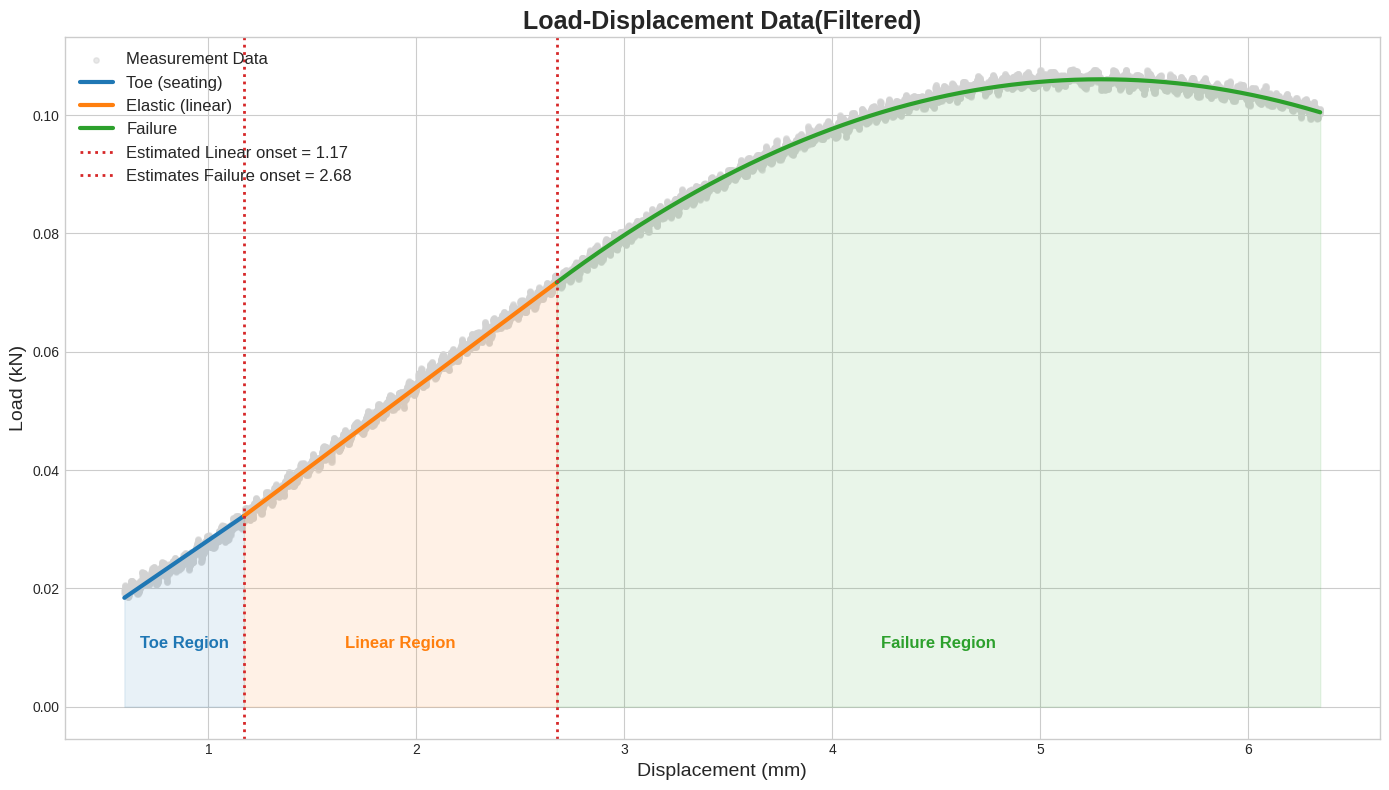

In [205]:
    if optimal_params:
        # --- 기존 코드 (데이터 재구성) ---
        c1, c2 = optimal_params['c1'], optimal_params['c2']
        m1, b1, m2, a3 = optimal_params['m1'], optimal_params['b1'], optimal_params['m2'], optimal_params['a3']

        x_fit1 = X_data[X_data < c1]
        y_fit1 = m1 * x_fit1 + b1

        x_fit2 = X_data[(X_data >= c1) & (X_data < c2)]
        y_fit2 = m2 * (x_fit2 - c1) + (m1 * c1 + b1)

        x_fit3 = X_data[X_data >= c2]
        f2_at_c2_fit = m2 * (c2 - c1) + (m1 * c1 + b1)
        y_fit3 = a3 * (x_fit3 - c2)**2 + m2 * (x_fit3 - c2) + f2_at_c2_fit


        plt.style.use('seaborn-v0_8-whitegrid')
        plt.figure(figsize=(14, 8))

        # 1. 원본 데이터 플로팅 (산점도)
        plt.scatter(X_data, Y_data, s=15, alpha=0.5, color='lightgray', label='Measurement Data')

        # 2. 각 구간별 함수를 다른 색상으로 플로팅
        plt.plot(x_fit1, y_fit1, color='#1f77b4', lw=3, label='Toe (seating)')
        plt.plot(x_fit2, y_fit2, color='#ff7f0e', lw=3, label='Elastic (linear)')
        plt.plot(x_fit3, y_fit3, color='#2ca02c', lw=3, label='Failure')

        # 3. 각 구간 영역을 반투명한 색상으로 채우기 (음영 처리)
        plt.fill_between(x_fit1, y_fit1, color='#1f77b4', alpha=0.1)
        plt.fill_between(x_fit2, y_fit2, color='#ff7f0e', alpha=0.1)
        plt.fill_between(x_fit3, y_fit3, color='#2ca02c', alpha=0.1)

        # 4. 접점(knot)을 명확하게 표시
        plt.axvline(x=c1, color='#d62728', linestyle=':', linewidth=2, label=f'Estimated Linear onset = {c1:.2f}')
        plt.axvline(x=c2, color='#d62728', linestyle=':', linewidth=2, label=f'Estimates Failure onset = {c2:.2f}')

        # 5. 각 구간에 텍스트 주석 추가
        y_min, y_max = plt.ylim()
        text_y_pos =0.01
        plt.text(x_fit1.mean(), text_y_pos, 'Toe Region', ha='center', fontsize=12, fontweight='bold', color='#1f77b4')
        plt.text(x_fit2.mean(), text_y_pos, 'Linear Region', ha='center', fontsize=12, fontweight='bold', color='#ff7f0e')
        plt.text(x_fit3.mean(), text_y_pos, 'Failure Region', ha='center', fontsize=12, fontweight='bold', color='#2ca02c')

        # 6. 제목 및 라벨, 범례 설정
        plt.title('Load-Displacement Data(Filtered)', fontsize=18, fontweight='bold')
        plt.xlabel('Displacement (mm)', fontsize=14)
        plt.ylabel('Load (kN)', fontsize=14)
        plt.legend(fontsize=12, loc='upper left')

        # 7. 그래프 레이아웃 최적화 및 표시
        plt.tight_layout()
        plt.show()

위에서 얻은 구간을 사용하여, 원본 데이터를 자른 후, 선형 회귀를 수행하여 실제  기울기 $m$와 $b$를 얻어야 하며, 이를 이용해 toe 오프셋 $c = -\frac{b}{m}$을 추정한다.

그 이후 원본 데이터에 빼준 후, 다시 선형 회귀를 수행하여 $m$값을 추정하였다.

In [206]:
start_x = 1.17
end_x = 2.68

X = df1["변위"].values
Y = df1["하중"].values
mask = (X > start_x) & (X < end_x)
A  = np.column_stack([X[mask],    np.ones(mask.sum())])
m1, b1 = np.linalg.lstsq(A, Y[mask], rcond=None)[0]
c = -b1/m1
X_tc = X - c
A2 = np.column_stack([X_tc[mask], np.ones(mask.sum())])
m2, b2 = np.linalg.lstsq(A2, Y[mask], rcond=None)[0]
print(m1, m2, b2)  # m1=m2, b2=0

0.026441018446681005 0.026441018446680998 2.9293677613026942e-18


In [207]:
start_x = 1.17
end_x   = 2.68

# --- First regression on ORIGINAL data in the window ---
mask_window = (X > start_x) & (X < end_x)
# If the window is too small, expand a little
if mask_window.sum() < 10:
    # expand by 10% of range iteratively
    for k in range(1,6):
        lo = start_x - k*0.05*(end_x-start_x)
        hi = end_x   + k*0.05*(end_x-start_x)
        mask_window = (X > lo) & (X < hi)
        if mask_window.sum() >= 10:
            start_x, end_x = lo, hi
            break

A = np.column_stack([X[mask_window], np.ones(mask_window.sum())])
m1, b1 = np.linalg.lstsq(A, Y[mask_window], rcond=None)[0]

# --- Toe compensation: global shift ---
c = -b1 / (m1 + 1e-18)
X_tc = X - c

# --- Second regression on the SAME indices, after correction ---
A2 = np.column_stack([X_tc[mask_window], np.ones(mask_window.sum())])
m2, b2 = np.linalg.lstsq(A2, Y[mask_window], rcond=None)[0]



0.1088


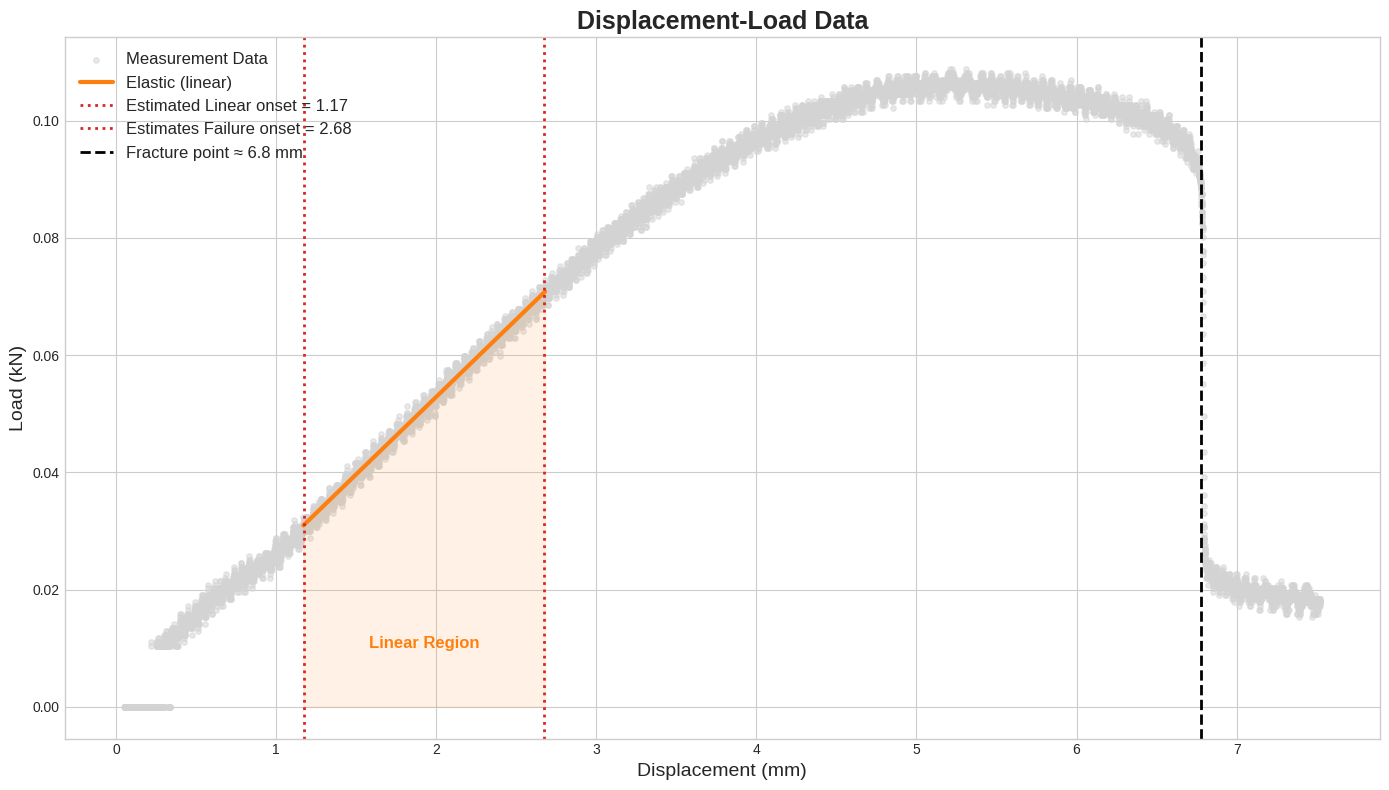

In [208]:
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(14, 8))

# 1. 원본 데이터 플로팅 (산점도)
plt.scatter(X_tc , Y, s=15, alpha=0.5, color='lightgray', label='Measurement Data')


max_load = np.max(Y)
print(max_load)


# 2. 각 구간별 함수를 다른 색상으로 플로팅

x_fit2 = X[(X >= start_x) & (X < end_x)]




y_fit2 = m2 * (x_fit2) + b2



plt.plot(x_fit2, y_fit2, color='#ff7f0e', lw=3, label='Elastic (linear)')

# 3. 각 구간 영역을 반투명한 색상으로 채우기 (음영 처리)
plt.fill_between(x_fit2, y_fit2, color='#ff7f0e', alpha=0.1)

# 4. 접점(knot)을 명확하게 표시
plt.axvline(x=c1, color='#d62728', linestyle=':', linewidth=2, label=f'Estimated Linear onset = {c1:.2f}')
plt.axvline(x=c2, color='#d62728', linestyle=':', linewidth=2, label=f'Estimates Failure onset = {c2:.2f}')

# 5. 각 구간에 텍스트 주석 추가
y_min, y_max = plt.ylim()
text_y_pos =0.01

plt.text(x_fit2.mean(), text_y_pos, 'Linear Region', ha='center', fontsize=12, fontweight='bold', color='#ff7f0e')
plt.axvline(x=6.78, color='black', linestyle='--', linewidth=2, label='Fracture point ≈ 6.8 mm')




# 6. 제목 및 라벨, 범례 설정
plt.title('Displacement-Load Data', fontsize=18, fontweight='bold')
plt.xlabel('Displacement (mm)', fontsize=14)
plt.ylabel('Load (kN)', fontsize=14)
plt.legend(fontsize=12, loc='upper left')

# 7. 그래프 레이아웃 최적화 및 표시
plt.tight_layout()
plt.show()

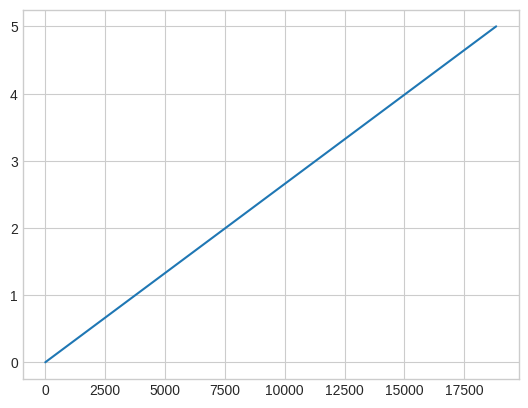

In [209]:
plt.plot(df1["변형율"].astype(float))
plt.show()

In [210]:
import numpy as np
i_peak = np.argmax(P)
thr = 0.85 * P[i_peak]                  # Pmax의 15%
after = np.arange(i_peak, len(P))
i_break = after[(P[i_peak:] <= thr)][0] # 첫 하강 진입
D_break = 6.78
P_break = P[i_break]                     # 파단 하중

In [187]:
print(D_break)  #

6.78


0.1088


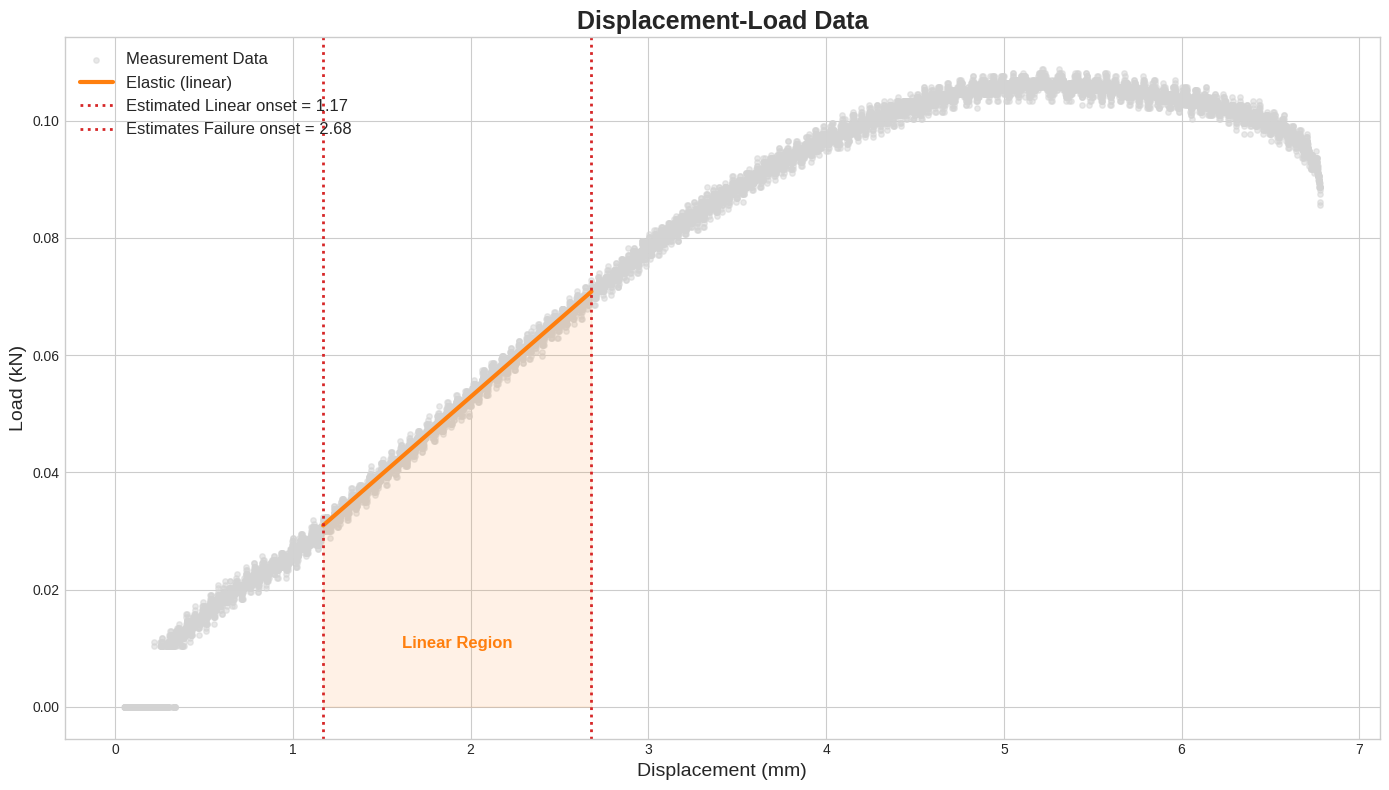

In [211]:
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(14, 8))

# 1. 원본 데이터 플로팅 (산점도)
plt.scatter(X_tc[X_tc < D_break] , Y[X_tc < D_break],  s=15, alpha=0.5, color='lightgray', label='Measurement Data')


max_load = np.max(Y)
print(max_load)


# 2. 각 구간별 함수를 다른 색상으로 플로팅

x_fit2 = X[(X >= start_x) & (X < end_x)]




y_fit2 = m2 * (x_fit2) + b2



plt.plot(x_fit2, y_fit2, color='#ff7f0e', lw=3, label='Elastic (linear)')

# 3. 각 구간 영역을 반투명한 색상으로 채우기 (음영 처리)
plt.fill_between(x_fit2, y_fit2, color='#ff7f0e', alpha=0.1)

# 4. 접점(knot)을 명확하게 표시
plt.axvline(x=c1, color='#d62728', linestyle=':', linewidth=2, label=f'Estimated Linear onset = {c1:.2f}')
plt.axvline(x=c2, color='#d62728', linestyle=':', linewidth=2, label=f'Estimates Failure onset = {c2:.2f}')

# 5. 각 구간에 텍스트 주석 추가
y_min, y_max = plt.ylim()
text_y_pos =0.01

plt.text(x_fit2.mean(), text_y_pos, 'Linear Region', ha='center', fontsize=12, fontweight='bold', color='#ff7f0e')




# 6. 제목 및 라벨, 범례 설정
plt.title('Displacement-Load Data', fontsize=18, fontweight='bold')
plt.xlabel('Displacement (mm)', fontsize=14)
plt.ylabel('Load (kN)', fontsize=14)
plt.legend(fontsize=12, loc='upper left')

# 7. 그래프 레이아웃 최적화 및 표시
plt.tight_layout()
plt.show()




In [189]:
print(m2)

0.026441018446680998


In [212]:
import numpy as np

L = 56.0       # 지간 [mm]
d = 3.5        # 두께 [mm]
b = 13.05        # 폭 [mm]
R_measured = 1.4933
D_5pct_given = 7.4667
# 추정 초기 기울기
m = 1000 * optimal_params['m2'] # [N/mm]

def flexural_modulus_from_m(m, L, b, d):
    """
    굽힘 탄성계수 E_B 계산 (MPa)
    공식: E_B = (L^3 * m) / (4 * b * d^3)  [N/mm^2 = MPa]
    """
    E = (L**3 * m) / (4.0 * b * d**3)  # 단위: MPa (N/mm^2)
    return E

E_from_given_m = flexural_modulus_from_m(m, L, b, d)  # MPa

## 변형율-강도 그래프를 통한 탄성 계수 추정

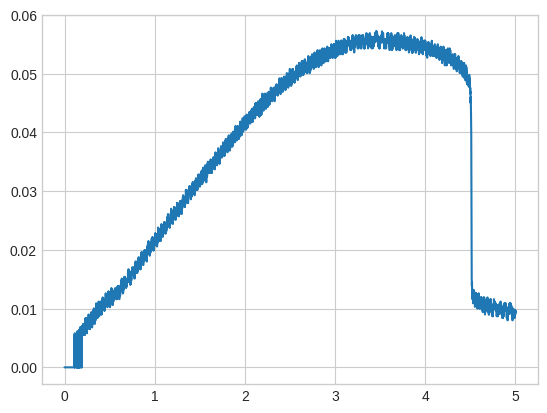

In [227]:
plt.plot(df1["변형율"].astype(float),df1["강도"].astype(float))

In [233]:
c2

np.float64(2.6753353523399745)

In [235]:
len(X_tc[X_tc > c2])

12219

In [242]:
import numpy as np
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt

arr = np.vstack([df1["변형율"].values, df1["강도"].values])  # (2, N)
arr_smooth = savgol_filter(arr, 11, 3, axis=1, mode='nearest')
print(arr_smooth)

[[5.68713287e-04 9.53482517e-04 1.37676690e-03 ... 5.00179869e+00
  5.00200746e+00 5.00216926e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 9.52097902e-03
  9.50699301e-03 9.47902098e-03]]


In [245]:
Y = arr_smooth[1]
W = arr_smooth[0]

if not np.all(np.diff(W) >= 0):
    idx = np.argsort(W)
    W, Y = W[idx], Y[idx]

m = 3000  # 창 크기
curv = []   # 각 창의 이차미분 값(= 2*alpha)
betas = []  # (alpha, beta, gamma) 저장(필요시)
starts = [] # 창 시작 인덱스 기록

for i in range(len(Y) - m + 1):
    y = Y[i:i+m]
    w = W[i:i+m]

    X = np.column_stack([w**2, w, np.ones_like(w)])
    coef = np.linalg.lstsq(X, y, rcond=None)[0]  # coef = [alpha, beta, gamma]
    alpha, beta, gamma  = coef

    curv.append(2.0 * alpha)   # 곡률
    betas.append((alpha, beta, gamma))
    starts.append(i)

curv = np.array(curv)
starts = np.array(starts)

# 시각화: 곡률 절댓값이 작을수록 더 '직선'에 가까움

# 가장 선형(곡률 최소) 창 선택
best_idx = np.argmin(np.abs(curv))
i0 = starts[best_idx]
alpha, beta, gamma = betas[best_idx]

y_win = Y[i0:i0+m]
w_win = W[i0:i0+m]
X_lin = np.column_stack([w_win, np.ones_like(w_win)])   # y ≈ a w + b
(a_lin, b_lin), *_ = np.linalg.lstsq(X_lin, y_win, rcond=None)

w_win = W[i0:i0+m]; y_win = Y[i0:i0+m]
A = np.column_stack([w_win, np.ones_like(w_win)])
a_lin, b_lin = np.linalg.lstsq(A, y_win, rcond=None)[0]

c = -b_lin / a_lin                 # Toe offset (mm)
W_tc = W - c                       # 전 구간 보정

print(f"Best window start: {i0}")


Best window start: 2257


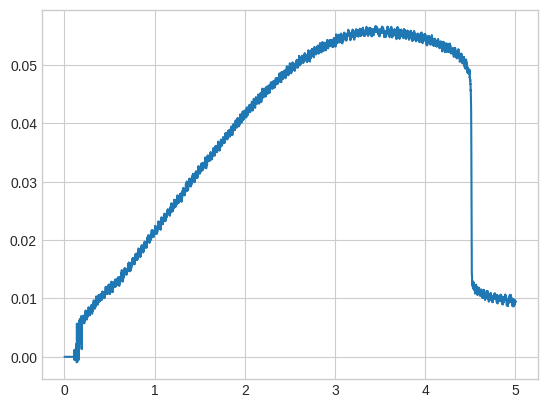

In [246]:
plt.plot(W,Y)

In [247]:
if __name__ == "__main__":

    Y_data = arr_smooth[1, i0:16000]
    X_data=  arr_smooth[0, i0:16000]
    # ----------------------------------------------------------------------

    optimal_params = find_best_piecewise_fit(X_data, Y_data, c1_candidates=40, c2_candidates=40)


    if optimal_params:
        c1, c2 = optimal_params['c1'], optimal_params['c2']
        m1, b1, m2, a3 = optimal_params['m1'], optimal_params['b1'], optimal_params['m2'], optimal_params['a3']

        x_fit1 = X_data[X_data < c1]
        y_fit1 = m1 * x_fit1 + b1

        x_fit2 = X_data[(X_data >= c1) & (X_data < c2)]
        y_fit2 = m2 * (x_fit2 - c1) + (m1 * c1 + b1)

        x_fit3 = X_data[X_data >= c2]
        f2_at_c2_fit = m2 * (c2 - c1) + (m1 * c1 + b1)
        y_fit3 = a3 * (x_fit3 - c2)**2 + m2 * (x_fit3 - c2) + f2_at_c2_fit

Start Optimization...


Grid Search Progress: 100%|██████████| 1600/1600 [02:33<00:00, 10.44it/s]


Optimziation End: (total time: 153.31sec)


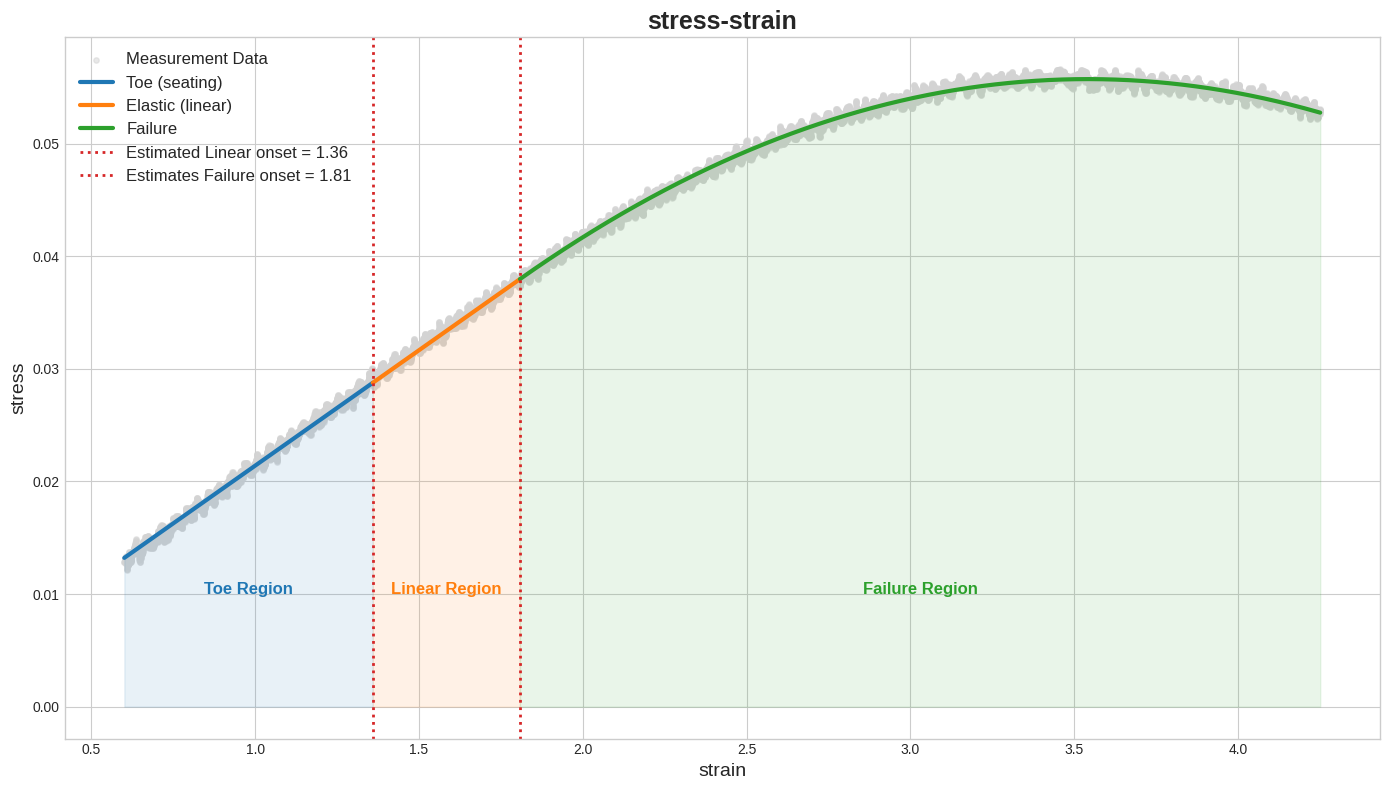

In [248]:
    if optimal_params:
        # --- 기존 코드 (데이터 재구성) ---
        c1, c2 = optimal_params['c1'], optimal_params['c2']
        m1, b1, m2, a3 = optimal_params['m1'], optimal_params['b1'], optimal_params['m2'], optimal_params['a3']

        x_fit1 = X_data[X_data < c1]
        y_fit1 = m1 * x_fit1 + b1

        x_fit2 = X_data[(X_data >= c1) & (X_data < c2)]
        y_fit2 = m2 * (x_fit2 - c1) + (m1 * c1 + b1)

        x_fit3 = X_data[X_data >= c2]
        f2_at_c2_fit = m2 * (c2 - c1) + (m1 * c1 + b1)
        y_fit3 = a3 * (x_fit3 - c2)**2 + m2 * (x_fit3 - c2) + f2_at_c2_fit


        plt.style.use('seaborn-v0_8-whitegrid')
        plt.figure(figsize=(14, 8))

        # 1. 원본 데이터 플로팅 (산점도)
        plt.scatter(X_data, Y_data, s=15, alpha=0.5, color='lightgray', label='Measurement Data')

        # 2. 각 구간별 함수를 다른 색상으로 플로팅
        plt.plot(x_fit1, y_fit1, color='#1f77b4', lw=3, label='Toe (seating)')
        plt.plot(x_fit2, y_fit2, color='#ff7f0e', lw=3, label='Elastic (linear)')
        plt.plot(x_fit3, y_fit3, color='#2ca02c', lw=3, label='Failure')

        # 3. 각 구간 영역을 반투명한 색상으로 채우기 (음영 처리)
        plt.fill_between(x_fit1, y_fit1, color='#1f77b4', alpha=0.1)
        plt.fill_between(x_fit2, y_fit2, color='#ff7f0e', alpha=0.1)
        plt.fill_between(x_fit3, y_fit3, color='#2ca02c', alpha=0.1)

        # 4. 접점(knot)을 명확하게 표시
        plt.axvline(x=c1, color='#d62728', linestyle=':', linewidth=2, label=f'Estimated Linear onset = {c1:.2f}')
        plt.axvline(x=c2, color='#d62728', linestyle=':', linewidth=2, label=f'Estimates Failure onset = {c2:.2f}')

        # 5. 각 구간에 텍스트 주석 추가
        y_min, y_max = plt.ylim()
        text_y_pos =0.01
        plt.text(x_fit1.mean(), text_y_pos, 'Toe Region', ha='center', fontsize=12, fontweight='bold', color='#1f77b4')
        plt.text(x_fit2.mean(), text_y_pos, 'Linear Region', ha='center', fontsize=12, fontweight='bold', color='#ff7f0e')
        plt.text(x_fit3.mean(), text_y_pos, 'Failure Region', ha='center', fontsize=12, fontweight='bold', color='#2ca02c')

        # 6. 제목 및 라벨, 범례 설정
        plt.title('stress-strain', fontsize=18, fontweight='bold')
        plt.xlabel('strain', fontsize=14)
        plt.ylabel('stress', fontsize=14)
        plt.legend(fontsize=12, loc='upper left')

        # 7. 그래프 레이아웃 최적화 및 표시
        plt.tight_layout()
        plt.show()

In [249]:
print(m2)

0.020500732594167365


In [256]:
data = {
    "시료크기":d*b ,
    "최대 하중":max_load,
    "굽힘 강도":df1["강도"].astype(float).iloc[len(X_tc[X_tc<D_break])],
    "최대 변위":D_break,
    "변형율": df1["변형율"].astype(float).iloc[len(X_tc[X_tc<D_break])],
    "계산 탄성 계수": E_from_given_m,
    "계측 탄성 계수": 100*1000*m2
}

df = pd.DataFrame([data])

df = df[["시료크기", "최대 하중", "굽힘 강도", "최대 변위", "변형율", "계산 탄성 계수","계측 탄성 계수"]]

# 노트북이면
display(df)  # 또는 print(df)


,시료크기,최대 하중,굽힘 강도,최대 변위,변형율,계산 탄성 계수,계측 탄성 계수
0,45.675,0.1088,0.0456,6.78,4.505692,2058.793317,2050.073259


In [257]:
import matplotlib.pyplot as plt
import pandas as pd
import pandas as pd
from urllib.parse import quote

base = "https://raw.githubusercontent.com/imrealhelper/Aerospace_experiment_2/main/"
fname = "굽힘시험 수평 raw.csv"
url = base + quote(fname)

df1 = pd.read_csv(url, encoding="cp949")
df1 = df1.iloc[1:]
display(df1)


,일련번호,시간,하중,변위,테이블,강도,변형율
1,1.0,0.000,0.0000,0.000000,0.001900,0.0000,0.000000
2,2.0,0.011,0.0000,0.002300,0.002300,0.0000,0.001540
3,3.0,0.027,0.0000,0.002700,0.002700,0.0000,0.001808
4,4.0,0.044,0.0000,0.003000,0.003000,0.0000,0.002009
5,5.0,0.061,0.0000,0.003400,0.003400,0.0000,0.002277
...,...,...,...,...,...,...,...
18826,18826.0,301.523,0.1283,7.468600,7.468600,0.0687,5.001295
18827,18827.0,301.537,0.1283,7.469000,7.469000,0.0687,5.001562
18828,18828.0,301.554,0.1283,7.469400,7.469400,0.0687,5.001830
18829,18829.0,301.570,0.1289,7.469800,7.469800,0.0691,5.002098


,일련번호,시간,하중,변위,테이블,강도,변형율
1,1.0,0.000,0.0000,0.000000,0.001900,0.0000,0.000000
2,2.0,0.011,0.0000,0.002300,0.002300,0.0000,0.001540
3,3.0,0.027,0.0000,0.002700,0.002700,0.0000,0.001808
4,4.0,0.044,0.0000,0.003000,0.003000,0.0000,0.002009
5,5.0,0.061,0.0000,0.003400,0.003400,0.0000,0.002277
...,...,...,...,...,...,...,...
18826,18826.0,301.523,0.1283,7.468600,7.468600,0.0687,5.001295
18827,18827.0,301.537,0.1283,7.469000,7.469000,0.0687,5.001562
18828,18828.0,301.554,0.1283,7.469400,7.469400,0.0687,5.001830
18829,18829.0,301.570,0.1289,7.469800,7.469800,0.0691,5.002098


[[9.44755245e-04 1.56433566e-03 2.23659674e-03 ... 7.46944289e+00
  7.46976270e+00 7.47000420e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.28417483e-01
  1.28424476e-01 1.28417483e-01]]
Best window start: 2570
Start Optimization...


Grid Search Progress: 100%|██████████| 1600/1600 [02:21<00:00, 11.30it/s]



Optimziation End: (total time: 141.64sec)


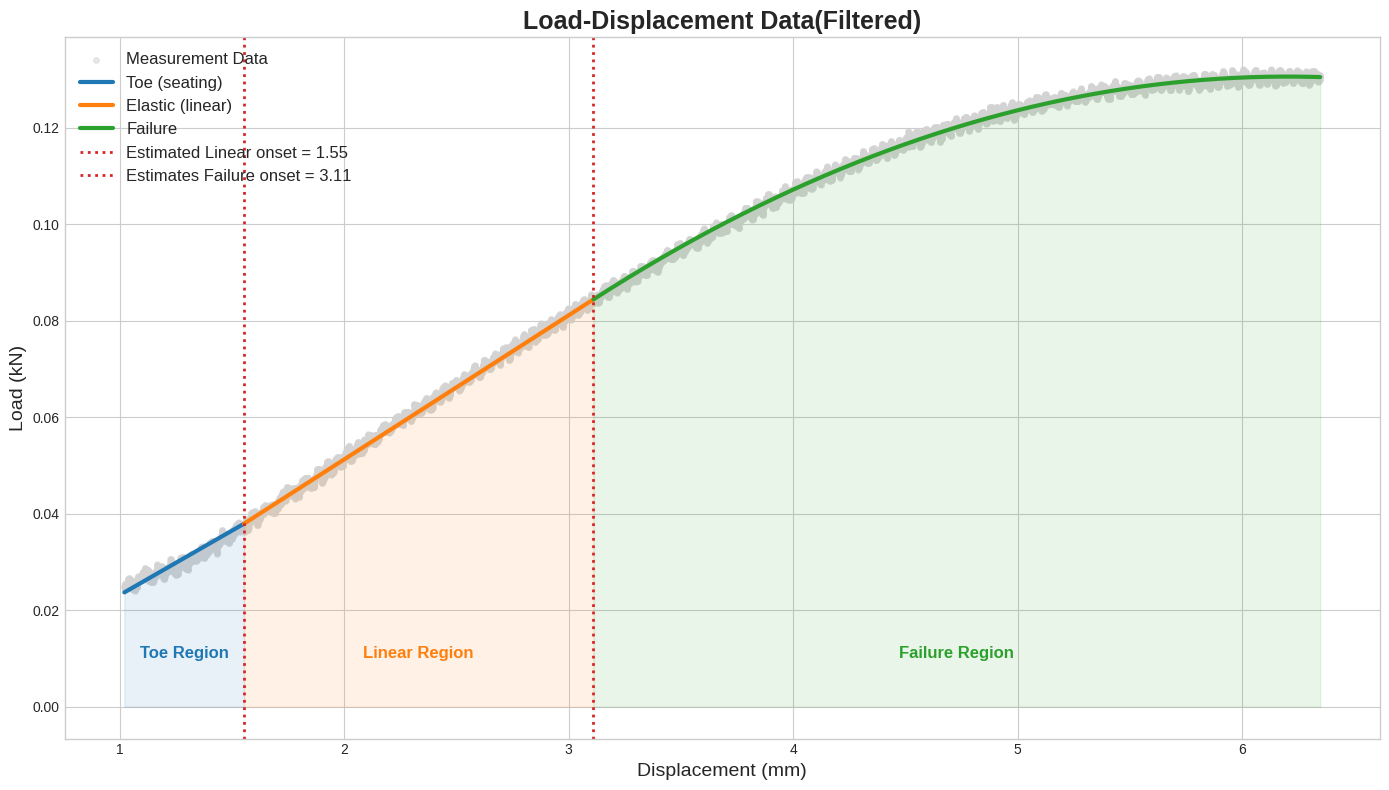

In [258]:

base = "https://raw.githubusercontent.com/imrealhelper/Aerospace_experiment_2/main/"
fname = "굽힘시험 수평 raw.csv"
url = base + quote(fname)

df1 = pd.read_csv(url, encoding="cp949")
df1 = df1.iloc[1:]
display(df1)

df1["변위"] = df1["변위"].astype(float)
df1["하중"] = df1["하중"].astype(float)
arr = np.vstack([df1["변위"].values, df1["하중"].values])  # (2, N)
arr_smooth = savgol_filter(arr, 11, 3, axis=1, mode='nearest')
print(arr_smooth)
Y = arr_smooth[1]
W = arr_smooth[0]

if not np.all(np.diff(W) >= 0):
    idx = np.argsort(W)
    W, Y = W[idx], Y[idx]

m = 6000  # 창 크기
curv = []   # 각 창의 이차미분 값(= 2*alpha)
betas = []  # (alpha, beta, gamma) 저장(필요시)
starts = [] # 창 시작 인덱스 기록

for i in range(len(Y) - m + 1):
    y = Y[i:i+m]
    w = W[i:i+m]

    X = np.column_stack([w**2, w, np.ones_like(w)])
    coef = np.linalg.lstsq(X, y, rcond=None)[0]  # coef = [alpha, beta, gamma]
    alpha, beta, gamma  = coef

    curv.append(2.0 * alpha)   # 곡률
    betas.append((alpha, beta, gamma))
    starts.append(i)

curv = np.array(curv)
starts = np.array(starts)

# 시각화: 곡률 절댓값이 작을수록 더 '직선'에 가까움

# 가장 선형(곡률 최소) 창 선택
best_idx = np.argmin(np.abs(curv))
i0 = starts[best_idx]
alpha, beta, gamma = betas[best_idx]

y_win = Y[i0:i0+m]
w_win = W[i0:i0+m]
X_lin = np.column_stack([w_win, np.ones_like(w_win)])   # y ≈ a w + b
(a_lin, b_lin), *_ = np.linalg.lstsq(X_lin, y_win, rcond=None)

w_win = W[i0:i0+m]; y_win = Y[i0:i0+m]
A = np.column_stack([w_win, np.ones_like(w_win)])
a_lin, b_lin = np.linalg.lstsq(A, y_win, rcond=None)[0]

c = -b_lin / a_lin                 # Toe offset (mm)
W_tc = W - c                       # 전 구간 보정

print(f"Best window start: {i0}")
if __name__ == "__main__":

    Y_data = arr_smooth[1, i0:16000]
    X_data=  arr_smooth[0, i0:16000]
    # ----------------------------------------------------------------------

    optimal_params = find_best_piecewise_fit(X_data, Y_data, c1_candidates=40, c2_candidates=40)


    if optimal_params:
        c1, c2 = optimal_params['c1'], optimal_params['c2']
        m1, b1, m2, a3 = optimal_params['m1'], optimal_params['b1'], optimal_params['m2'], optimal_params['a3']

        x_fit1 = X_data[X_data < c1]
        y_fit1 = m1 * x_fit1 + b1

        x_fit2 = X_data[(X_data >= c1) & (X_data < c2)]
        y_fit2 = m2 * (x_fit2 - c1) + (m1 * c1 + b1)

        x_fit3 = X_data[X_data >= c2]
        f2_at_c2_fit = m2 * (c2 - c1) + (m1 * c1 + b1)
        y_fit3 = a3 * (x_fit3 - c2)**2 + m2 * (x_fit3 - c2) + f2_at_c2_fit

    if optimal_params:
        # --- 기존 코드 (데이터 재구성) ---
        c1, c2 = optimal_params['c1'], optimal_params['c2']
        m1, b1, m2, a3 = optimal_params['m1'], optimal_params['b1'], optimal_params['m2'], optimal_params['a3']

        x_fit1 = X_data[X_data < c1]
        y_fit1 = m1 * x_fit1 + b1

        x_fit2 = X_data[(X_data >= c1) & (X_data < c2)]
        y_fit2 = m2 * (x_fit2 - c1) + (m1 * c1 + b1)

        x_fit3 = X_data[X_data >= c2]
        f2_at_c2_fit = m2 * (c2 - c1) + (m1 * c1 + b1)
        y_fit3 = a3 * (x_fit3 - c2)**2 + m2 * (x_fit3 - c2) + f2_at_c2_fit


        plt.style.use('seaborn-v0_8-whitegrid')
        plt.figure(figsize=(14, 8))

        # 1. 원본 데이터 플로팅 (산점도)
        plt.scatter(X_data, Y_data, s=15, alpha=0.5, color='lightgray', label='Measurement Data')

        # 2. 각 구간별 함수를 다른 색상으로 플로팅
        plt.plot(x_fit1, y_fit1, color='#1f77b4', lw=3, label='Toe (seating)')
        plt.plot(x_fit2, y_fit2, color='#ff7f0e', lw=3, label='Elastic (linear)')
        plt.plot(x_fit3, y_fit3, color='#2ca02c', lw=3, label='Failure')

        # 3. 각 구간 영역을 반투명한 색상으로 채우기 (음영 처리)
        plt.fill_between(x_fit1, y_fit1, color='#1f77b4', alpha=0.1)
        plt.fill_between(x_fit2, y_fit2, color='#ff7f0e', alpha=0.1)
        plt.fill_between(x_fit3, y_fit3, color='#2ca02c', alpha=0.1)

        # 4. 접점(knot)을 명확하게 표시
        plt.axvline(x=c1, color='#d62728', linestyle=':', linewidth=2, label=f'Estimated Linear onset = {c1:.2f}')
        plt.axvline(x=c2, color='#d62728', linestyle=':', linewidth=2, label=f'Estimates Failure onset = {c2:.2f}')

        # 5. 각 구간에 텍스트 주석 추가
        y_min, y_max = plt.ylim()
        text_y_pos =0.01
        plt.text(x_fit1.mean(), text_y_pos, 'Toe Region', ha='center', fontsize=12, fontweight='bold', color='#1f77b4')
        plt.text(x_fit2.mean(), text_y_pos, 'Linear Region', ha='center', fontsize=12, fontweight='bold', color='#ff7f0e')
        plt.text(x_fit3.mean(), text_y_pos, 'Failure Region', ha='center', fontsize=12, fontweight='bold', color='#2ca02c')

        # 6. 제목 및 라벨, 범례 설정
        plt.title('Load-Displacement Data(Filtered)', fontsize=18, fontweight='bold')
        plt.xlabel('Displacement (mm)', fontsize=14)
        plt.ylabel('Load (kN)', fontsize=14)
        plt.legend(fontsize=12, loc='upper left')

        # 7. 그래프 레이아웃 최적화 및 표시
        plt.tight_layout()
        plt.show()

0.1332


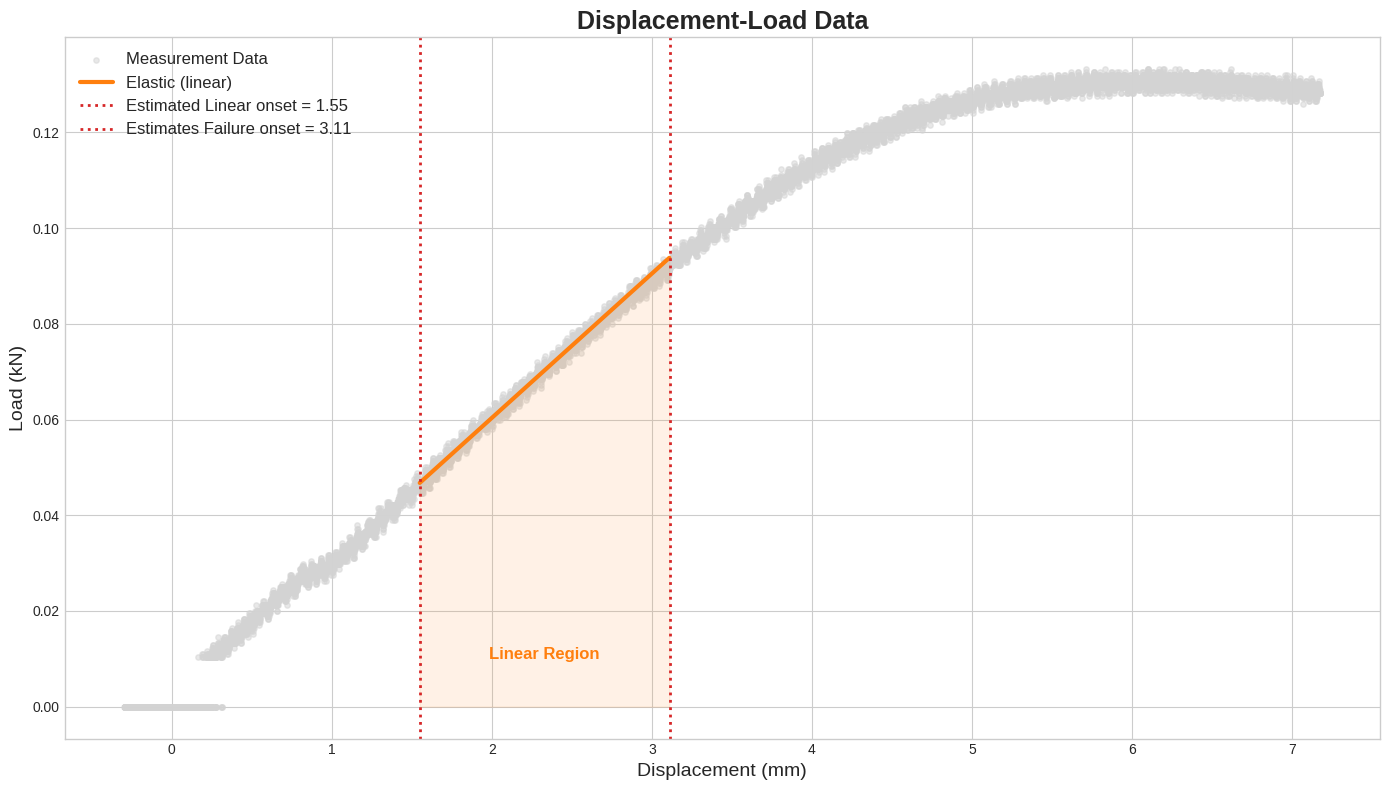

In [259]:
start_x = 1.55
end_x = 3.11

X = df1["변위"].values
Y = df1["하중"].values
mask = (X > start_x) & (X < end_x)
A  = np.column_stack([X[mask],    np.ones(mask.sum())])
m1, b1 = np.linalg.lstsq(A, Y[mask], rcond=None)[0]
c = -b1/m1
X_tc = X - c
A2 = np.column_stack([X_tc[mask], np.ones(mask.sum())])
m2, b2 = np.linalg.lstsq(A2, Y[mask], rcond=None)[0]


# --- First regression on ORIGINAL data in the window ---
mask_window = (X > start_x) & (X < end_x)
# If the window is too small, expand a little
if mask_window.sum() < 10:
    # expand by 10% of range iteratively
    for k in range(1,6):
        lo = start_x - k*0.05*(end_x-start_x)
        hi = end_x   + k*0.05*(end_x-start_x)
        mask_window = (X > lo) & (X < hi)
        if mask_window.sum() >= 10:
            start_x, end_x = lo, hi
            break

A = np.column_stack([X[mask_window], np.ones(mask_window.sum())])
m1, b1 = np.linalg.lstsq(A, Y[mask_window], rcond=None)[0]

# --- Toe compensation: global shift ---
c = -b1 / (m1 + 1e-18)
X_tc = X - c

# --- Second regression on the SAME indices, after correction ---
A2 = np.column_stack([X_tc[mask_window], np.ones(mask_window.sum())])
m2, b2 = np.linalg.lstsq(A2, Y[mask_window], rcond=None)[0]


plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(14, 8))

# 1. 원본 데이터 플로팅 (산점도)
plt.scatter(X_tc , Y, s=15, alpha=0.5, color='lightgray', label='Measurement Data')


max_load = np.max(Y)
print(max_load)


# 2. 각 구간별 함수를 다른 색상으로 플로팅

x_fit2 = X[(X >= start_x) & (X < end_x)]




y_fit2 = m2 * (x_fit2) + b2



plt.plot(x_fit2, y_fit2, color='#ff7f0e', lw=3, label='Elastic (linear)')

# 3. 각 구간 영역을 반투명한 색상으로 채우기 (음영 처리)
plt.fill_between(x_fit2, y_fit2, color='#ff7f0e', alpha=0.1)

# 4. 접점(knot)을 명확하게 표시
plt.axvline(x=c1, color='#d62728', linestyle=':', linewidth=2, label=f'Estimated Linear onset = {c1:.2f}')
plt.axvline(x=c2, color='#d62728', linestyle=':', linewidth=2, label=f'Estimates Failure onset = {c2:.2f}')

# 5. 각 구간에 텍스트 주석 추가
y_min, y_max = plt.ylim()
text_y_pos =0.01

plt.text(x_fit2.mean(), text_y_pos, 'Linear Region', ha='center', fontsize=12, fontweight='bold', color='#ff7f0e')
#plt.axvline(x=6.78, color='black', linestyle='--', linewidth=2, label='Fracture point ≈ 6.8 mm')




# 6. 제목 및 라벨, 범례 설정
plt.title('Displacement-Load Data', fontsize=18, fontweight='bold')
plt.xlabel('Displacement (mm)', fontsize=14)
plt.ylabel('Load (kN)', fontsize=14)
plt.legend(fontsize=12, loc='upper left')

# 7. 그래프 레이아웃 최적화 및 표시
plt.tight_layout()
plt.show()

In [260]:
import numpy as np

L = 56.0       # 지간 [mm]
d = 3.5       # 두께 [mm]
b = 12.8        # 폭 [mm]
R_measured = 1.4933  # 크로스헤드 속도 [mm/min]
# 추정 초기 기울기
m = 1000 * optimal_params['m2'] # [N/mm]

def flexural_modulus_from_m(m, L, b, d):
    """
    굽힘 탄성계수 E_B 계산 (MPa)
    공식: E_B = (L^3 * m) / (4 * b * d^3)  [N/mm^2 = MPa]
    """
    E = (L**3 * m) / (4.0 * b * d**3)  # 단위: MPa (N/mm^2)
    return E

E_from_given_m = flexural_modulus_from_m(m, L, b, d)  # MPa

In [261]:
data = {
    "시료크기":d*b ,
    "최대 하중":max_load,
    "굽힘 강도":df1["강도"].astype(float).iloc[len(X_tc)-1],
    "최대 변위":np.max(X_tc),
    "변형율": df1["변형율"].astype(float).iloc[len(X_tc)-1],
    "탄성 계수": E_from_given_m,
}

df = pd.DataFrame([data])

df = df[["시료크기", "최대 하중", "굽힘 강도", "최대 변위", "변형율", "탄성 계수"]]

# 노트북이면
display(df)  # 또는 print(df)

,시료크기,최대 하중,굽힘 강도,최대 변위,변형율,탄성 계수
0,44.8,0.1332,0.0687,7.175368,5.002366,2389.856228


In [263]:
df1["변형율"] = df1["변형율"].astype(float)
df1["강도"] = df1["강도"].astype(float)

In [265]:
import numpy as np
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt

arr = np.vstack([df1["변형율"].values, df1["강도"].values])  # (2, N)
arr_smooth = savgol_filter(arr, 11, 3, axis=1, mode='nearest')
print(arr_smooth)

[[6.32589744e-04 1.04758508e-03 1.49778322e-03 ... 5.00185894e+00
  5.00207305e+00 5.00223475e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 6.87783217e-02
  6.87829837e-02 6.87783217e-02]]


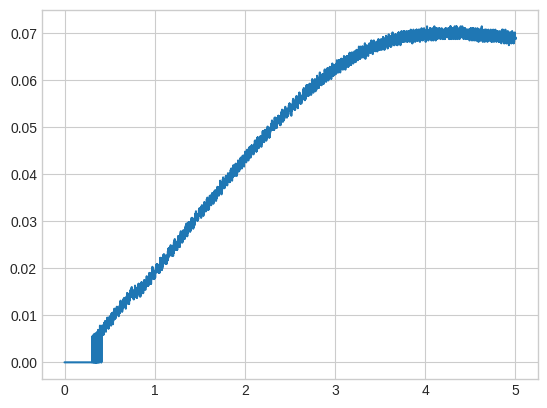

[[6.32589744e-04 1.04758508e-03 1.49778322e-03 ... 5.00185894e+00
  5.00207305e+00 5.00223475e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 6.87783217e-02
  6.87829837e-02 6.87783217e-02]]
Best window start: 309
Start Optimization...


Grid Search Progress: 100%|██████████| 1600/1600 [02:42<00:00,  9.83it/s]



Optimziation End: (total time: 162.81sec)


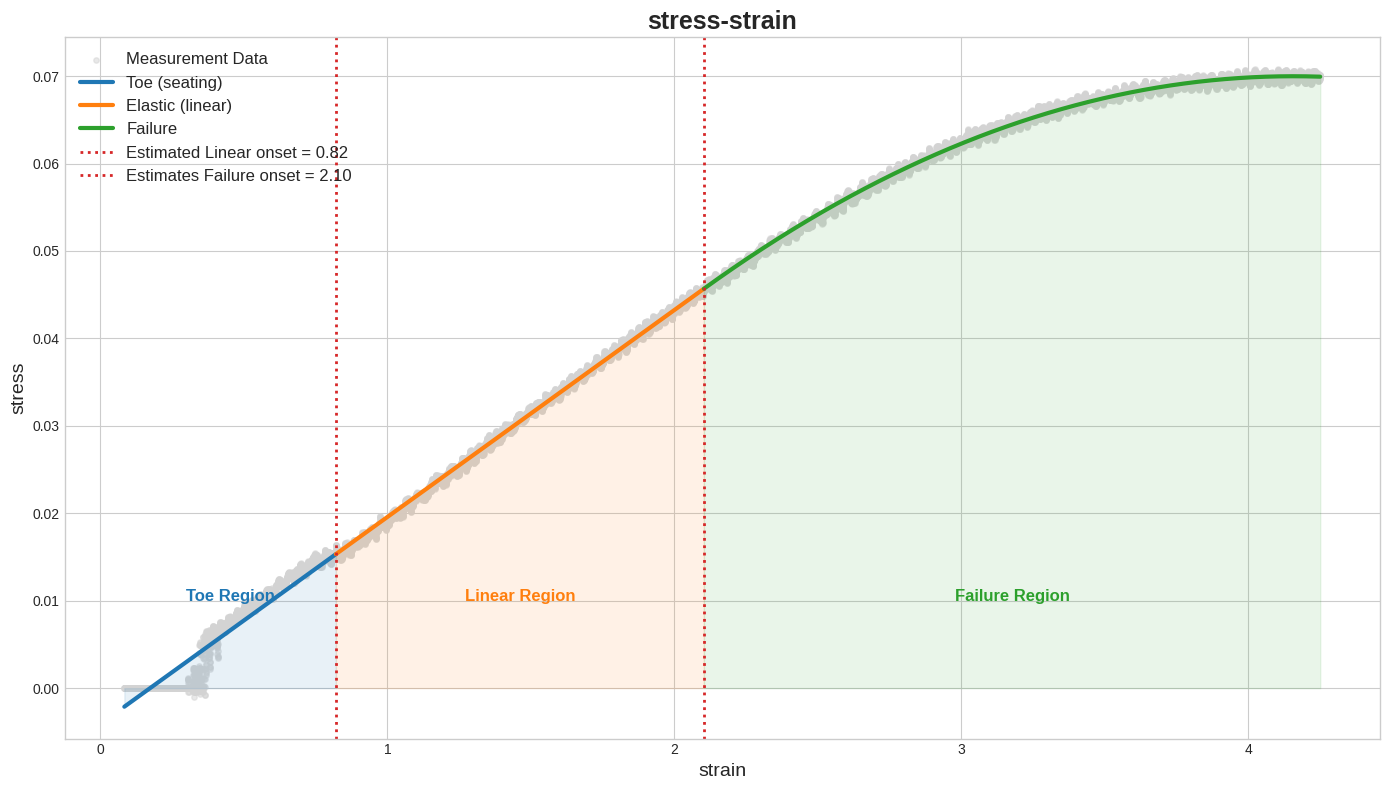

In [267]:
plt.plot(df1["변형율"].astype(float),df1["강도"].astype(float))
plt.show()
arr = np.vstack([df1["변형율"].values, df1["강도"].values])  # (2, N)
arr_smooth = savgol_filter(arr, 11, 3, axis=1, mode='nearest')
print(arr_smooth)
Y = arr_smooth[1]
W = arr_smooth[0]

if not np.all(np.diff(W) >= 0):
    idx = np.argsort(W)
    W, Y = W[idx], Y[idx]

m = 3000  # 창 크기
curv = []   # 각 창의 이차미분 값(= 2*alpha)
betas = []  # (alpha, beta, gamma) 저장(필요시)
starts = [] # 창 시작 인덱스 기록

for i in range(len(Y) - m + 1):
    y = Y[i:i+m]
    w = W[i:i+m]

    X = np.column_stack([w**2, w, np.ones_like(w)])
    coef = np.linalg.lstsq(X, y, rcond=None)[0]  # coef = [alpha, beta, gamma]
    alpha, beta, gamma  = coef

    curv.append(2.0 * alpha)   # 곡률
    betas.append((alpha, beta, gamma))
    starts.append(i)

curv = np.array(curv)
starts = np.array(starts)

# 시각화: 곡률 절댓값이 작을수록 더 '직선'에 가까움

# 가장 선형(곡률 최소) 창 선택
best_idx = np.argmin(np.abs(curv))
i0 = starts[best_idx]
alpha, beta, gamma = betas[best_idx]

y_win = Y[i0:i0+m]
w_win = W[i0:i0+m]
X_lin = np.column_stack([w_win, np.ones_like(w_win)])   # y ≈ a w + b
(a_lin, b_lin), *_ = np.linalg.lstsq(X_lin, y_win, rcond=None)

w_win = W[i0:i0+m]; y_win = Y[i0:i0+m]
A = np.column_stack([w_win, np.ones_like(w_win)])
a_lin, b_lin = np.linalg.lstsq(A, y_win, rcond=None)[0]

c = -b_lin / a_lin                 # Toe offset (mm)
W_tc = W - c                       # 전 구간 보정

print(f"Best window start: {i0}")
if __name__ == "__main__":

    Y_data = arr_smooth[1, i0:16000]
    X_data=  arr_smooth[0, i0:16000]
    # ----------------------------------------------------------------------

    optimal_params = find_best_piecewise_fit(X_data, Y_data, c1_candidates=40, c2_candidates=40)


    if optimal_params:
        c1, c2 = optimal_params['c1'], optimal_params['c2']
        m1, b1, m2, a3 = optimal_params['m1'], optimal_params['b1'], optimal_params['m2'], optimal_params['a3']

        x_fit1 = X_data[X_data < c1]
        y_fit1 = m1 * x_fit1 + b1

        x_fit2 = X_data[(X_data >= c1) & (X_data < c2)]
        y_fit2 = m2 * (x_fit2 - c1) + (m1 * c1 + b1)

        x_fit3 = X_data[X_data >= c2]
        f2_at_c2_fit = m2 * (c2 - c1) + (m1 * c1 + b1)
        y_fit3 = a3 * (x_fit3 - c2)**2 + m2 * (x_fit3 - c2) + f2_at_c2_fit
    if optimal_params:
        # --- 기존 코드 (데이터 재구성) ---
        c1, c2 = optimal_params['c1'], optimal_params['c2']
        m1, b1, m2, a3 = optimal_params['m1'], optimal_params['b1'], optimal_params['m2'], optimal_params['a3']

        x_fit1 = X_data[X_data < c1]
        y_fit1 = m1 * x_fit1 + b1

        x_fit2 = X_data[(X_data >= c1) & (X_data < c2)]
        y_fit2 = m2 * (x_fit2 - c1) + (m1 * c1 + b1)

        x_fit3 = X_data[X_data >= c2]
        f2_at_c2_fit = m2 * (c2 - c1) + (m1 * c1 + b1)
        y_fit3 = a3 * (x_fit3 - c2)**2 + m2 * (x_fit3 - c2) + f2_at_c2_fit


        plt.style.use('seaborn-v0_8-whitegrid')
        plt.figure(figsize=(14, 8))

        # 1. 원본 데이터 플로팅 (산점도)
        plt.scatter(X_data, Y_data, s=15, alpha=0.5, color='lightgray', label='Measurement Data')

        # 2. 각 구간별 함수를 다른 색상으로 플로팅
        plt.plot(x_fit1, y_fit1, color='#1f77b4', lw=3, label='Toe (seating)')
        plt.plot(x_fit2, y_fit2, color='#ff7f0e', lw=3, label='Elastic (linear)')
        plt.plot(x_fit3, y_fit3, color='#2ca02c', lw=3, label='Failure')

        # 3. 각 구간 영역을 반투명한 색상으로 채우기 (음영 처리)
        plt.fill_between(x_fit1, y_fit1, color='#1f77b4', alpha=0.1)
        plt.fill_between(x_fit2, y_fit2, color='#ff7f0e', alpha=0.1)
        plt.fill_between(x_fit3, y_fit3, color='#2ca02c', alpha=0.1)

        # 4. 접점(knot)을 명확하게 표시
        plt.axvline(x=c1, color='#d62728', linestyle=':', linewidth=2, label=f'Estimated Linear onset = {c1:.2f}')
        plt.axvline(x=c2, color='#d62728', linestyle=':', linewidth=2, label=f'Estimates Failure onset = {c2:.2f}')

        # 5. 각 구간에 텍스트 주석 추가
        y_min, y_max = plt.ylim()
        text_y_pos =0.01
        plt.text(x_fit1.mean(), text_y_pos, 'Toe Region', ha='center', fontsize=12, fontweight='bold', color='#1f77b4')
        plt.text(x_fit2.mean(), text_y_pos, 'Linear Region', ha='center', fontsize=12, fontweight='bold', color='#ff7f0e')
        plt.text(x_fit3.mean(), text_y_pos, 'Failure Region', ha='center', fontsize=12, fontweight='bold', color='#2ca02c')

        # 6. 제목 및 라벨, 범례 설정
        plt.title('stress-strain', fontsize=18, fontweight='bold')
        plt.xlabel('strain', fontsize=14)
        plt.ylabel('stress', fontsize=14)
        plt.legend(fontsize=12, loc='upper left')

        # 7. 그래프 레이아웃 최적화 및 표시
        plt.tight_layout()
        plt.show()


In [269]:
data = {
    "시료크기":d*b ,
    "최대 하중":max_load,
    "굽힘 강도":df1["강도"].astype(float).iloc[len(X_tc)-1],
    "최대 변위":np.max(X_tc),
    "변형율": df1["변형율"].astype(float).iloc[len(X_tc)-1],
    "계산 탄성 계수": E_from_given_m,
    "계측 탄성 계수": 100*1000*m2
}

df = pd.DataFrame([data])

df = df[["시료크기", "최대 하중", "굽힘 강도", "최대 변위", "변형율", "계산 탄성 계수","계측 탄성 계수"]]

# 노트북이면
display(df)  # 또는 print(df)

,시료크기,최대 하중,굽힘 강도,최대 변위,변형율,계산 탄성 계수,계측 탄성 계수
0,44.8,0.0714,0.0687,5.127264,5.002366,2389.856228,2366.931025
